# M5 Forecasting Challenge
Некоторые заметки:
- Используем метрику: **Weighted Root Mean Squared Scaled Error** (RMSSE)
<img src="rmse.jpg"/>
- Нам поручено прогнозировать иерархические данные о продажах Wal-Mart
- Данные охватывают магазины в трех штатах США (Калифорния, Техас и Висконсин) и включают уровень товара, отдел, категории продуктов и информацию о магазинах.
- Кроме того, у него есть поясняющие переменные, такие как цена, акции, день недели и особые события.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import lightgbm as lgb
from matplotlib.pyplot import figure
from matplotlib import dates as mdates
from tqdm import tqdm
import datetime as dt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Data Files
- `calendar.csv` - Содержит информацию о датах продажи товаров.
- `sales_train_validation.csv` - Содержит исторические данные о продажах за день по продукту и магазину [d_1 - d_1913]
- `sample_submission.csv` - Правильный формат для сабмита
- `sell_prices.csv` - Содержит информацию о цене проданных товаров в каждом магазине и дате.
- `sales_train_evaluation.csv` - Включает продажи с [d_1 - d_1941] (labels used for the Public leaderboard)

In [40]:
# Читаем данные
cal = pd.read_csv('calendar.csv')
stv = pd.read_csv('sales_train_validation.csv')
ss = pd.read_csv('sample_submission.csv')
sellp = pd.read_csv('sell_prices.csv')

# Что мы должны предсказывать?
Мы попытаемся предсказывать продажи на следующие 28 дней. Конечный файл должен содержать следующее:
- Столбцы представляют 28 дней прогноза. Мы наполним эти прогнозные дни нашими прогнозами.
- Каждая строка представляет собой конкретный элемент. Этот идентификатор сообщает нам тип, состояние и хранилище элемента. Мы не знаем, что именно это за предметы.

In [41]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


У нас есть история продаж в  `sales_train_validation` датасете.
- строки в датасете состоят из дней d_1 to d_1913. Нам дается идентификатор отдела, категории, штата и магазина.
- d_1914 - d_1941 представляют `validation` строки, которые мы будем прогнозировать на этапе 1
- d_1942 - d_1969 представляют `evaluation` строки, которые мы спрогнозируем для окончательного зачета соревнований.

In [42]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


# Визуализация данных для одного товара
- Давайте возьмем случайный товар, который много продается, и посмотрим, как его продажи выглядят на основе данных обучения.
- `FOODS_3_090_CA_3_validation` продается достаточно много
- Обратите внимание, что есть дни, когда товар недоступен, а продажи фиксируются.

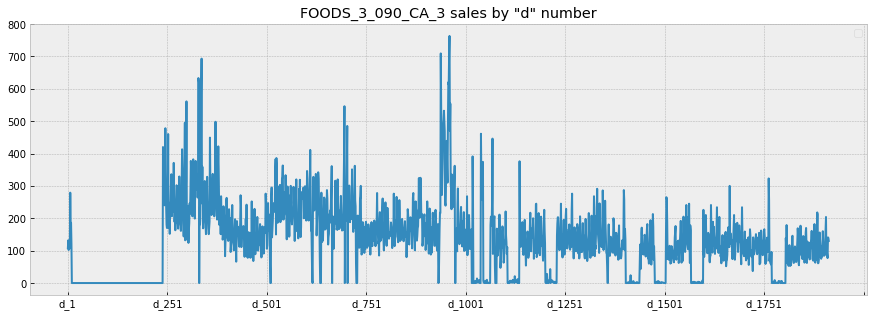

In [43]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Ниже мы объединяем следующие шаги в pandas:
# 1. Выбираем товар
# 2. Установите идентификатор в качестве индекса, оставьте только столбцы данных о продажах
# 3. Преобразуйте так, чтобы получился столбец
# 4. Отобразите данные
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

## Смержим данные с реальными датами
- Нам дается календарь с дополнительной информацией о прошедших и будущих датах.
- Данные календаря могут быть объединены с данными наших дней
- Отсюда мы можем найти еженедельные и годовые тенденции.

In [44]:
# Данные календаря выглядят следующим образом (отображаются только те столбцы, которые нам нужны на данный момент)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


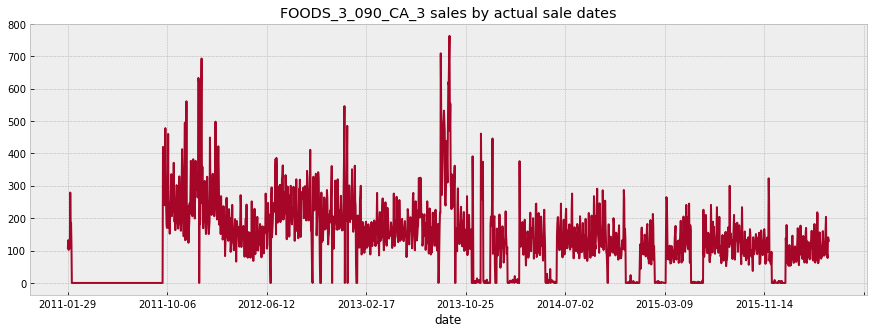

In [45]:
# Объединить календарь с данными о наших товарах
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Назовем их корректно
example = example.reset_index().rename(columns={'index': 'd'}) # добавим "d" индекс
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Выберите больше самых продаваемых примеров
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Назовем их корректно
example2 = example2.reset_index().rename(columns={'index': 'd'}) # добавим "d" индекс
example2 = example2.merge(cal, how='left', validate='1:1')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Назовем их корректно
example3 = example3.reset_index().rename(columns={'index': 'd'}) # добавим "d" индекс
example3 = example3.merge(cal, how='left', validate='1:1')

# Продажи с разбивкой по временным переменным
- Теперь, когда у нас есть наш пример товара, давайте посмотрим, как он продается:
    - День недели
    - Месяц
    - Год

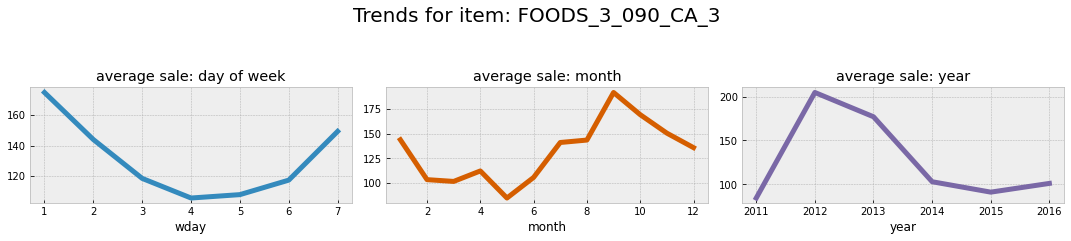

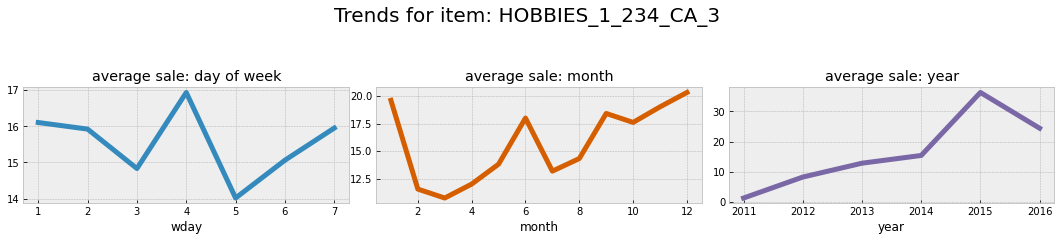

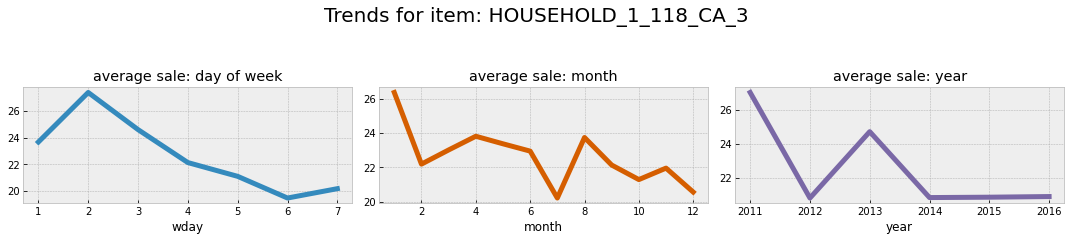

In [46]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

# Посмотрим на большее кол-во товаров
- Давайте соберем все вместе, чтобы построить 20 различных предметов и их продажи.
- Некоторые наблюдения с этих графиков:
    - Обычно товар недоступен в течение определенного периода времени.
    - Некоторые предметы продаются только 1 или меньше в день, поэтому их очень сложно предсказать.
    - На другие товары наблюдается всплеск их спроса. Кажется, что предоставленные нам "мероприятия" могут помочь с этим.

In [47]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

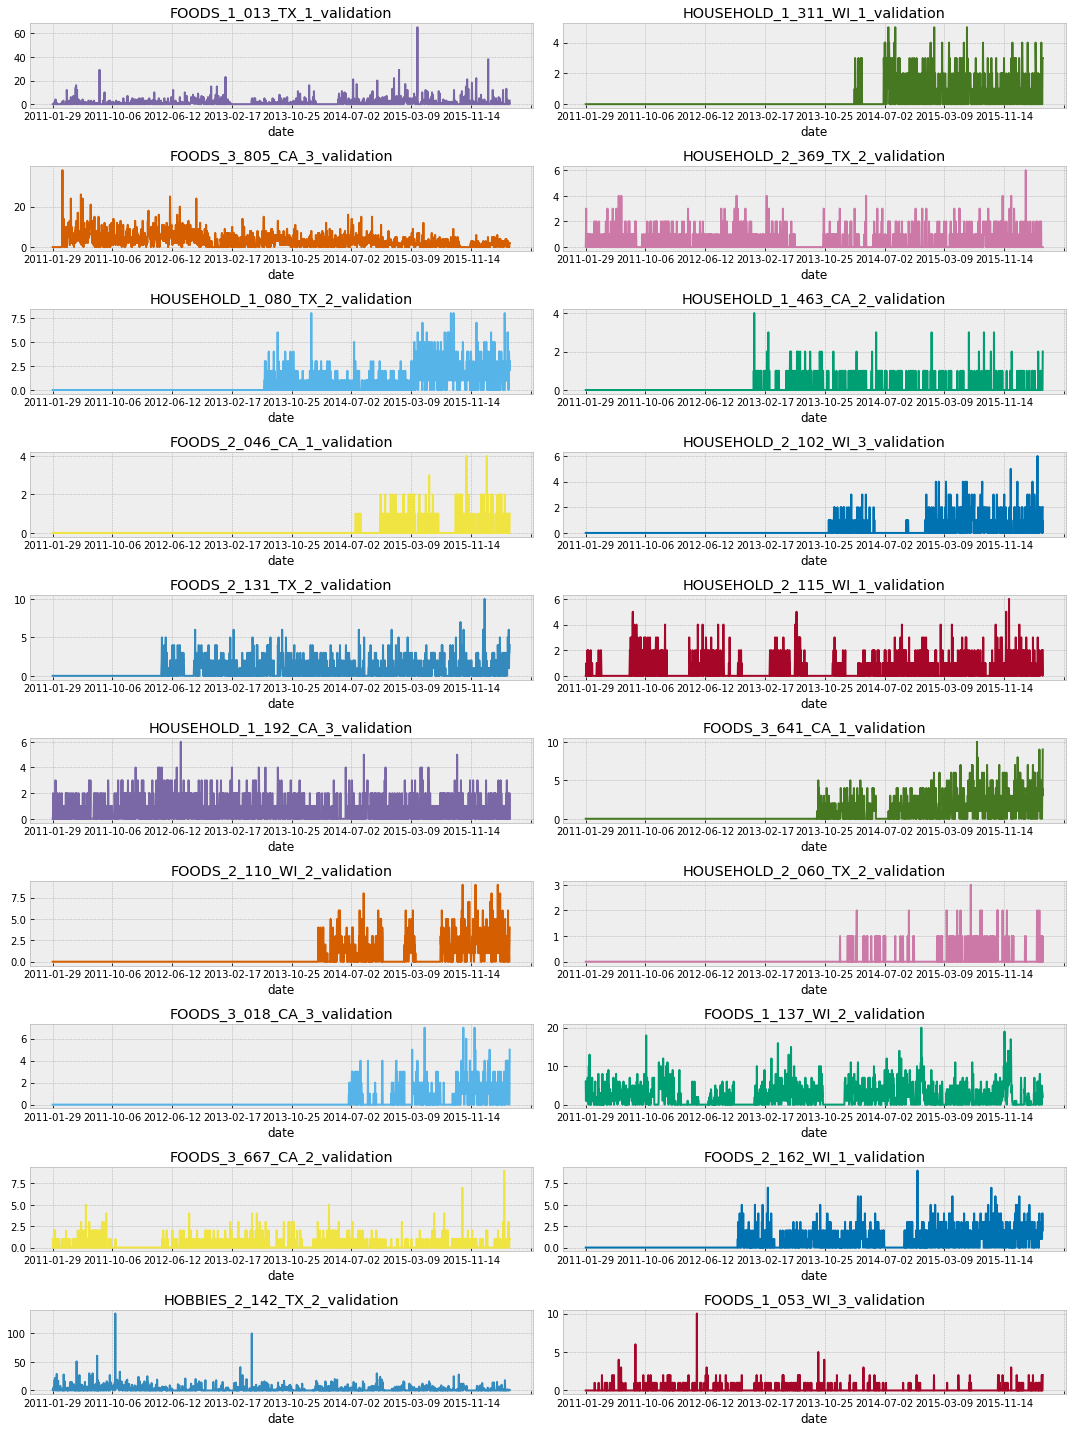

In [48]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

# Комбинированные продажи с течением времени по типу
- У нас есть несколько типов товаров:
    - Hobbies
    - Household
    - Foods
- Построим график общего спроса с течением времени для каждого типа

In [49]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

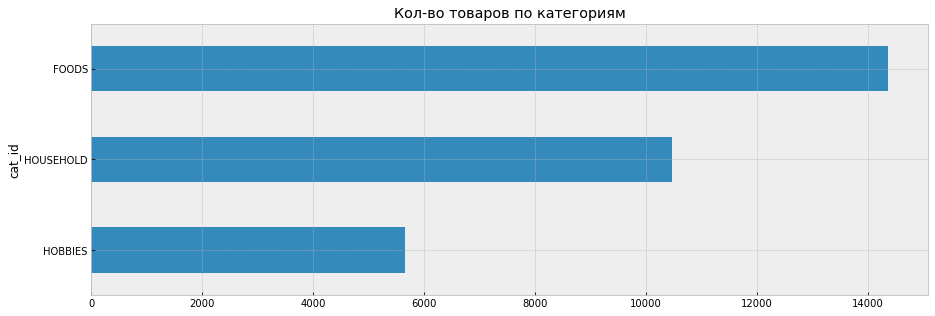

In [50]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Кол-во товаров по категориям')
plt.show()

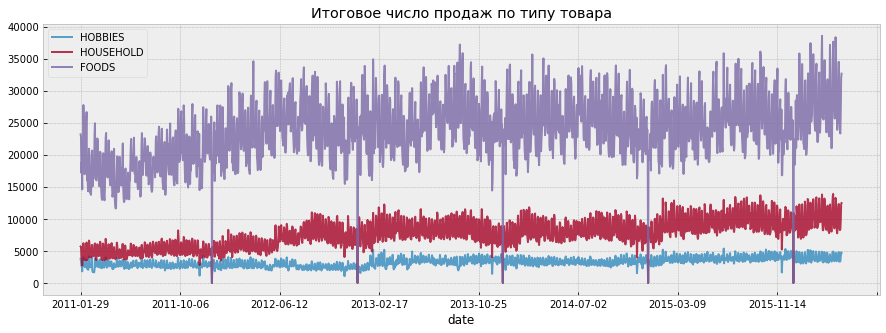

In [51]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Итоговое число продаж по типу товара')
plt.legend(stv['cat_id'].unique())
plt.show()

# Некоторые выводы по графику
- Можно увидеть, что в поставку поступают некоторые предметы, которых раньше не было. Аналогичным образом некоторые предметы перестают продаваться полностью.
- Построим график продаж, но посчитаем только если товар продается или не продается (0 -> не продается, >0 -> продается)
- Этот график показывает нам, что многие предметы медленно вводятся в инвентарь, поэтому многие из них не регистрируют продажу в начале предоставленных данных.

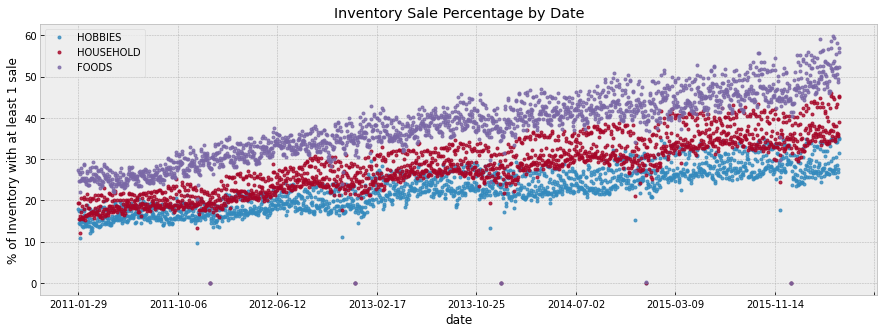

In [52]:
past_sales_clipped = past_sales.clip(0, 1)
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(stv['cat_id'].unique())
plt.show()

# Продажи по магазинам
Приведены данные по 10 уникальным магазинам. Каковы общие продажи по магазинам?
- Обратите внимание, что одни магазины более стабильны, чем другие.
- Кажется что CA_2 продажи после 2015 пойдут вверх

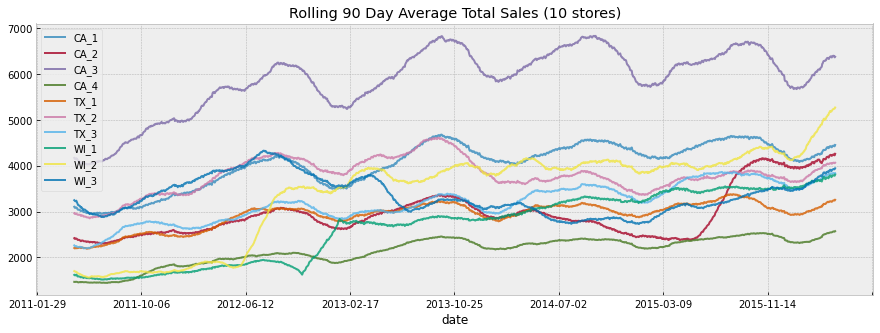

In [53]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Взглянув на те же данные с другой стороны, мы можем построить скользящий 7-дневный общий объем спроса по магазинам. Обратите внимание на то, что в некоторых магазинах резко меняется спрос: возможно, магазин расширился или поблизости появился новый конкурент. В любом случае это важно учитывать при создании прогнозных моделей структуры спроса.

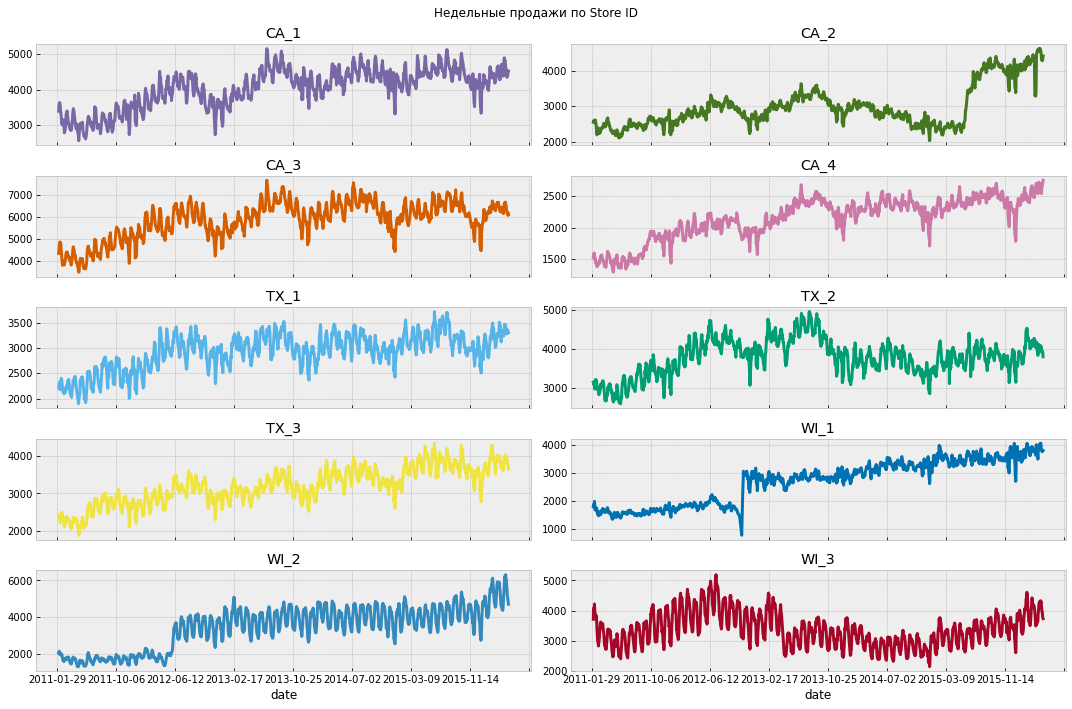

In [54]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Недельные продажи по Store ID')
plt.tight_layout()
plt.show()

# Heatmap Calendar продаж

In [55]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

Похоже, что в день Рождества волмарты закрыты. Самый высокий спрос среди всех данных пришелся на воскресенье, 6 марта 2016 года. Что произошло в этот день?[седьмые дебаты кандидатов в президенты от Демократической партии, организованные CNN во Флинте, штат Мичиган] (https: // www.onthisday.com/date/2016/march/6)

In [56]:
print('Дата с наименьшим числом продаж:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('Дата с наибольшим числом продаж:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')

Дата с наименьшим числом продаж: 2012-12-25 with 11 sales
Дата с наибольшим числом продаж: 2016-03-06 with 57218 sales


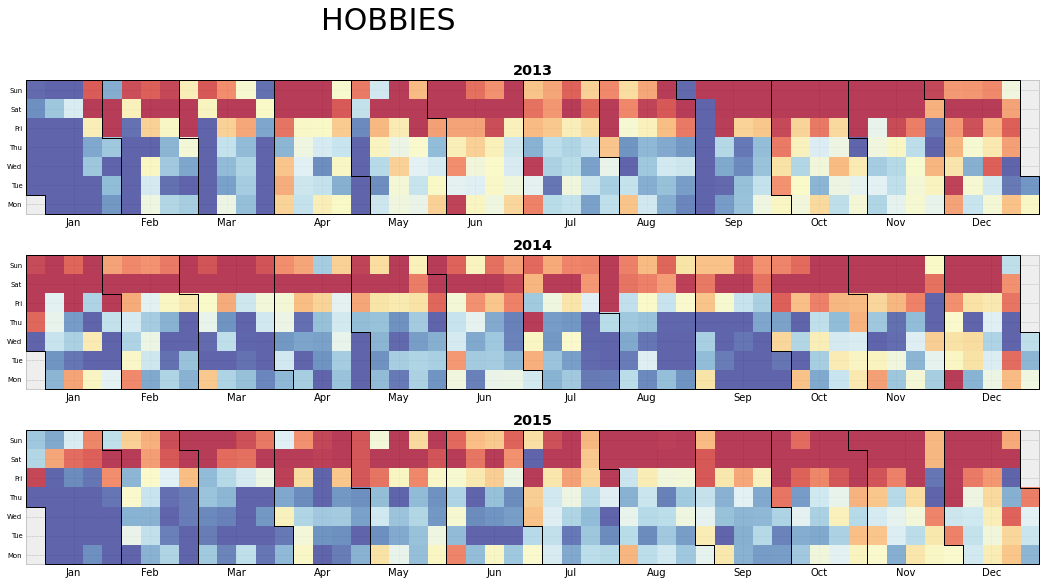

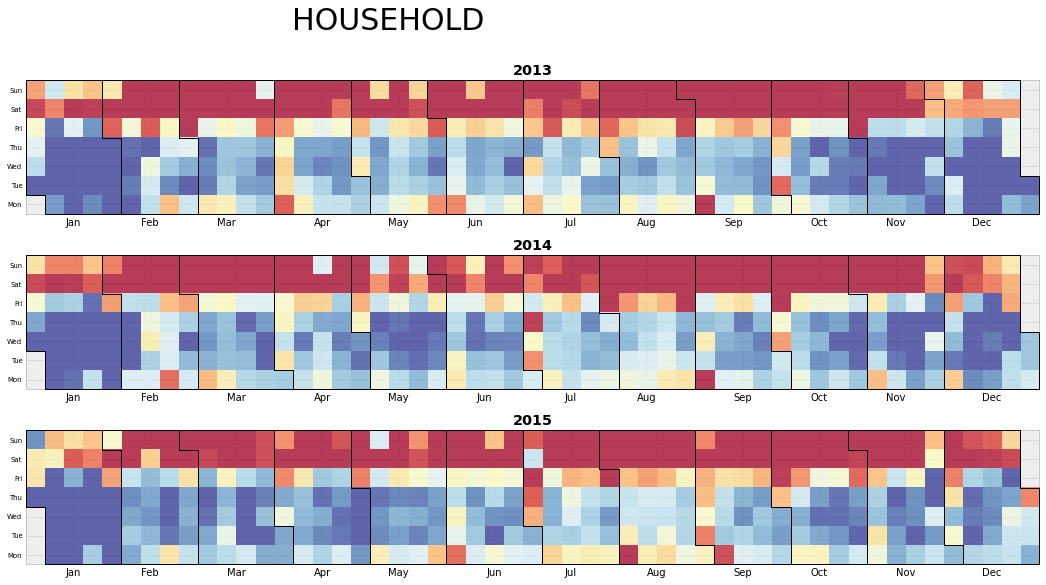

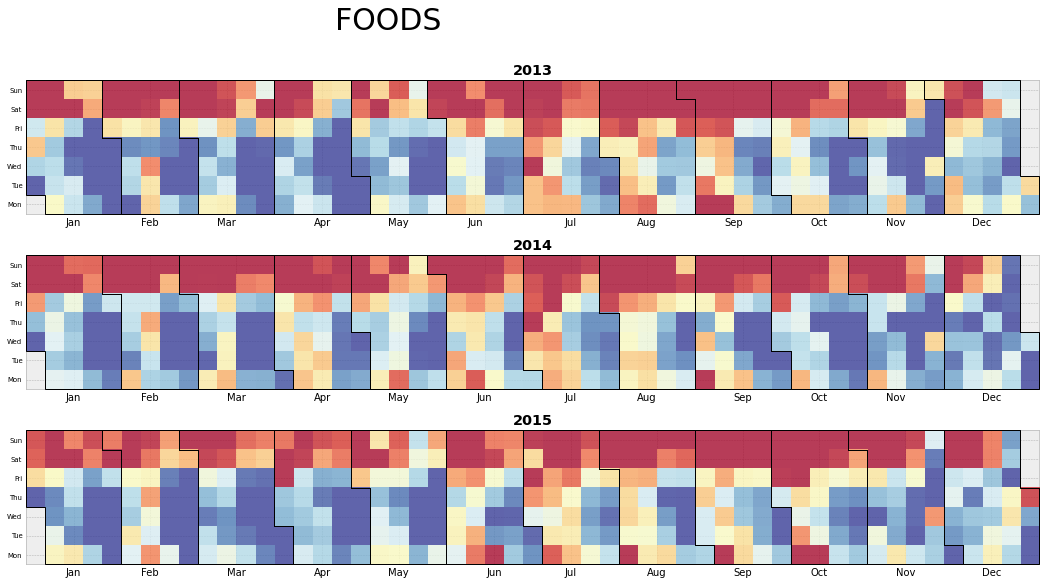

In [57]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in stv['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

Некоторые вывод по этим heapmap'ам:
- В течение месяца количество покупок продуктов питания, как правило, уменьшается. Может быть, это потому, что люди получают зарплату в начале месяца?
- Household and Hobby товары продаются намного меньше в январе - после окончания курортного сезона.

# Цены продажи
Нам даны исторические цены продажи каждой позиции. Давайте посмотрим на наш пример элемента ранее.
- Кажется, что цена на этот товар растет.
- В разных магазинах разные цены.

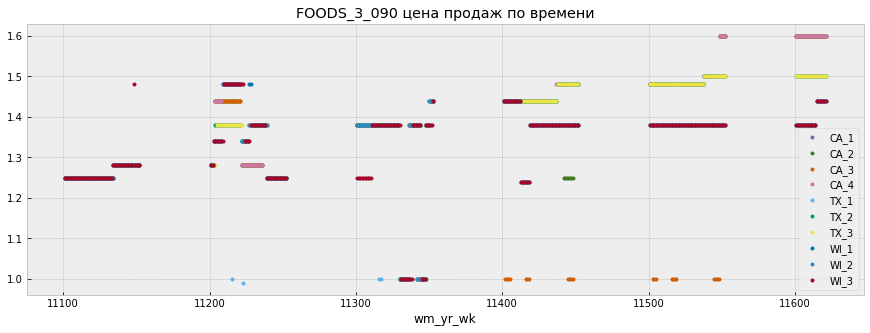

In [58]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sellp.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 цена продаж по времени',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

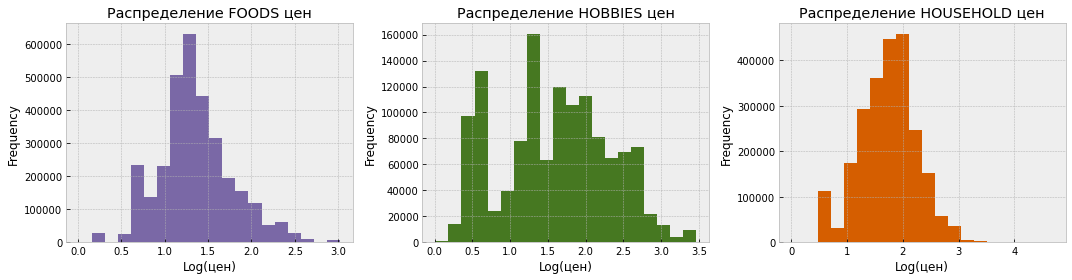

In [59]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sellp.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Распределение {cat} цен',
                         ax=axs[i],
                                         color=next(color_cycle))
    ax.set_xlabel('Log(цен)')
    i += 1
plt.tight_layout()

# Начало решения

### Читаем данные

In [60]:
sell_prices = pd.read_csv('sell_prices.csv')
sample_submission = pd.read_csv('sample_submission.csv')
calendar = pd.read_csv('calendar.csv')
sales_train_validation = pd.read_csv('sales_train_evaluation.csv')

## Работаем с данными
### Приводим их в нужный нам вид

In [61]:
sales_data = pd.DataFrame(sales_train_validation).reset_index()
for i in range(1942, 1972):
    sales_data['d_' + str(i)] = 0

In [62]:
sell_prices = pd.read_csv('sell_prices.csv')
sell_prices['id'] = sell_prices['item_id'] + '_' + sell_prices['store_id']
sell_prices = sell_prices.pivot(index='id', columns = 'wm_yr_wk', values = 'sell_price').reset_index()
sell_prices = sell_prices.fillna(method='bfill', axis=1)
test = sales_data['item_id'] + '_' + sales_data['store_id']
sell_prices = sell_prices.set_index('id')
sell_prices = sell_prices.reindex(test)
sell_prices = sell_prices.reset_index()

### Обробатываем данные праздников и скидок

In [63]:
labels = calendar[['d', 'event_name_1', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI', 'wday', 'month', 'year', 'wm_yr_wk']].reset_index()
labels = labels.fillna(0)
#labels['wm_yr_wk'] = int(labels['wm_yr_wk'])
labels['event_name_1'] = labels['event_name_1'].astype('str')
labels['event_name_2'] = labels['event_name_2'].astype('str')

In [64]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
label_encoder = label_encoder.fit(labels['event_name_1'])
label_encoded_event1 = label_encoder.transform(labels['event_name_1'])
label_encoder = label_encoder.fit(labels['event_name_2'])
label_encoded_event2 = label_encoder.transform(labels['event_name_2'])
labels['event_name_1_encode'] = label_encoded_event1
labels['event_name_2_encode'] = label_encoded_event2

### Смотрим на результаты преобразований

In [65]:
labels

,index,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,wday,month,year,wm_yr_wk,event_name_1_encode,event_name_2_encode
0,0,d_1,0,0,0,0,0,1,1,2011,11101,0,0
1,1,d_2,0,0,0,0,0,2,1,2011,11101,0,0
2,2,d_3,0,0,0,0,0,3,1,2011,11101,0,0
3,3,d_4,0,0,1,1,0,4,2,2011,11101,0,0
4,4,d_5,0,0,1,0,1,5,2,2011,11101,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,1964,d_1965,0,0,0,1,1,5,6,2016,11620,0,0
1965,1965,d_1966,0,0,0,0,0,6,6,2016,11620,0,0
1966,1966,d_1967,0,0,0,0,0,7,6,2016,11620,0,0
1967,1967,d_1968,0,0,0,0,0,1,6,2016,11621,0,0


# Настраиваем параметры модели

## Графики предсказаний

In [66]:
#lgbm Model
params = {

#         'boosting_type': 'gbdt',
        'force_col_wise':True,
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 20,
        'learning_rate': 0.1,
        'alpha': 0.1,
        'lambda': 0.1,
        'bagging_fraction': 0.66,
        'bagging_freq': 2, 
        'colsample_bytree': 0.77,
        'verbosity': -1
}

In [67]:
count_valid_days = 41

In [76]:
ss[[f'F{x}' for x in range(29,count_valid_days+29)]] = 0.

In [77]:
ss

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,...,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56,F57,F58,F59,F60,F61,F62,F63,F64,F65,F66,F67,F68,F69
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60976,FOODS_3_824_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60977,FOODS_3_825_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60978,FOODS_3_826_WI_3_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Начинаем обучение

In [78]:
#hide-input
for i in tqdm(range(0, len(sales_data))): # Проходим по всем имеющимся данным (которые мы ранее преобразовали)
    temp = pd.DataFrame(sales_data.loc[i][7:]).reset_index()
    temp = temp.rename(columns = {"index": "d", i: "sales"})
    sales_all = labels.merge(temp, on=["d"])
    sales_all = sales_all.merge(sell_prices.reset_index().loc[i], on=['wm_yr_wk'])
    
    # Здесь мы считаем средние и стандартные отклонения
    sales_all['lag_28'] = sales_all['sales'].shift(28)

    sales_all['rolling_std_t7'] = sales_all[i].transform(lambda x: x.rolling(7).std())
    sales_all['rolling_std_t30'] = sales_all[i].transform(lambda x: x.rolling(30).std())
    
    sales_all['rolling_mean_7'] = sales_all['sales'].transform(lambda x: x.shift(28).rolling(7).mean())
    sales_all['rolling_mean_30'] = sales_all['sales'].transform(lambda x: x.shift(28).rolling(30).mean())
    sales_all['rolling_mean_60'] = sales_all['sales'].transform(lambda x: x.shift(28).rolling(60).mean())
    
    sales_all['lag_price_t1'] = sales_all[i].transform(lambda x: x.shift(1))   
    sales_all['price_change_t1'] = (sales_all['lag_price_t1'] - sales_all[i]) / sales_all['lag_price_t1']
    
    sales_all.drop(['lag_price_t1'], inplace = True, axis = 1)
    
    # Соединяем посчитанные признаки с исходными
    features = ['event_name_1_encode', 'event_name_2_encode', 'snap_' + sales_data['state_id'][i]
                , 'wday','month', 'year'
                , 'lag_28'
                , 'rolling_std_t7', 'rolling_std_t30'
                , 'rolling_mean_7', 'rolling_mean_30', 'rolling_mean_60'
                , 'price_change_t1', i]
    features_sales = ['event_name_1_encode', 'event_name_2_encode', 'snap_' + sales_data['state_id'][i]
                , 'wday','month', 'year'
                , 'lag_28'
                , 'rolling_std_t7', 'rolling_std_t30'
                , 'rolling_mean_7', 'rolling_mean_30', 'rolling_mean_60'
                , 'price_change_t1',i, 'sales']
    
    sales_all[features_sales] = sales_all[features_sales].applymap(float)

    # А здесь происходит магия...
    X_train = lgb.Dataset(sales_all[features][0:1940]
                      , label = sales_all[['sales']][0:1940])
    clf = lgb.train(params, X_train)
    y_pred = clf.predict(sales_all[features][1941-count_valid_days:])
   
    ss.iloc[i+30490, 1:] = y_pred
    if i == 100:
        break

  0%|▏                                                                           | 100/30490 [00:47<4:01:09,  2.10it/s]


### Формируем csv файл с нашими предсказаниями

In [79]:
ss.to_csv("submission.csv", index=False)

# Анализ файла предсказаний

In [80]:
sub = pd.read_csv("submission.csv")

In [81]:
columns = sub.id
sub.drop(['id'],inplace=True,axis=1)
sub = sub.T
sub['date'] = [dt.date(2016,4,25)+dt.timedelta(days=x)-dt.timedelta(days=count_valid_days) for x in range(len(sub))]
sub = sub.set_index('date')
sub.columns = columns.values

## Графики предсказаний

На данных графиках мы можем видеть, красной линией - то что предсказала наша модель, а синей - то что было в данных
Наша модель неплохо справляется с данной задачей предсказаний

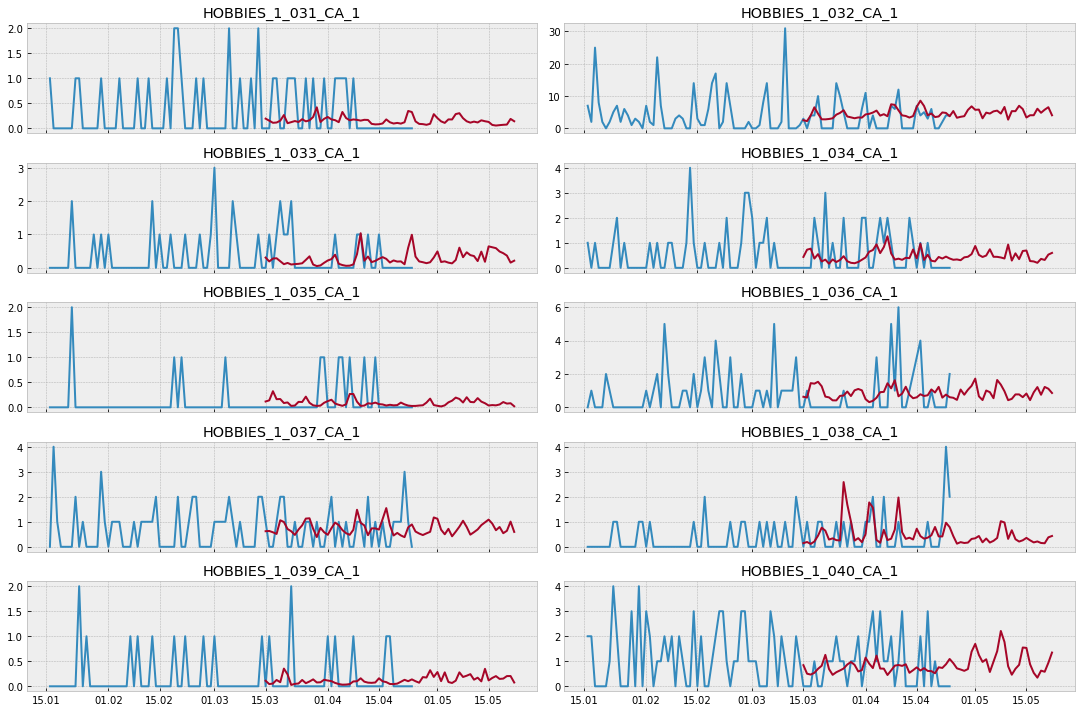

In [82]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

ax_idx = 0
for s in past_sales.columns[30:]:
    item = "_".join(s.split('_')[:-1])
    axes[ax_idx].set_title(item)
    axes[ax_idx].xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    axes[ax_idx].plot(past_sales.index[-100:],past_sales[f"{item}_validation"][-100:],sub.index,sub[f"{item}_evaluation"])
    ax_idx += 1
    if ax_idx == 10:
        break
plt.tight_layout()
plt.show()